# Vegetation Early Warning System and Reporting Pipeline

**Author:** Evan Hodson  
**Date:** 2025-10-25  
**Purpose:** Probabilistic model to assess low vegetation cover risk using rainfall data

## 1. Imports & Configuration

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import percentileofscore
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score, roc_auc_score
)
import numpy as np
import os
from typing import Tuple, Dict
import warnings
from IPython.display import display, Math

# Suppress warnings for cleaner notebook output
warnings.filterwarnings('ignore')

# -----------------------------
# Configuration Classes
# -----------------------------
class Config:
    """Global configuration for the analysis"""
    ROLLING_WINDOW = 12  # months for cumulative rainfall
    INITIAL_TRAIN_MONTHS = 120  # initial training window in months
    LOW_COVER_THRESHOLD = 0.10  # percentile threshold for low cover
    PROB_THRESHOLD = 0.5  # threshold for logistic classification

class ColorScheme:
    """Color scheme for consistent visualization"""
    VEGETATION = '#2ca02c'
    RAINFALL = '#1f77b4'
    RISK_HIGH = '#d62728'
    ANOMALY = '#ff7f0e'
    PROBABILITY = '#9467bd'

# Set default Seaborn style
sns.set_palette("Set2")
sns.set_style("whitegrid")

## 2. Data Loading & Preparation

In [16]:
def load_and_prepare_data(filepath: str) -> pd.DataFrame:
    """
    Load CSV and prepare a time-indexed dataframe.

    Parameters
    ----------
    filepath : str
        Path to CSV file with columns: 'year', 'month', 'mean_cover', 'mean_rainfall'

    Returns
    -------
    pd.DataFrame
        Time-indexed dataframe sorted by date
    """
    df = pd.read_csv(filepath)
    required_cols = {'year', 'month', 'mean_cover', 'mean_rainfall'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"CSV must contain columns: {required_cols}")
    
    df['date'] = pd.to_datetime(dict(year=df['year'], month=df['month'], day=15))
    df = df.sort_values('date').reset_index(drop=True)
    return df

def compute_seasonal_cycle(df: pd.DataFrame) -> pd.Series:
    """Compute average cover per month across all years"""
    return df.groupby('month')['mean_cover'].mean()

def compute_cover_anomalies(df: pd.DataFrame, seasonal_cover: pd.Series) -> pd.DataFrame:
    """Compute cover anomalies as deviation from seasonal average"""
    df = df.copy()
    df['cover_anomaly'] = df['mean_cover'] - df['month'].map(seasonal_cover)
    return df

def compute_rolling_rainfall(df: pd.DataFrame, window: int = Config.ROLLING_WINDOW) -> pd.DataFrame:
    """Calculate rolling cumulative rainfall"""
    df = df.copy()
    df['rain_12mo'] = df['mean_rainfall'].rolling(window=window, min_periods=window).sum()
    return df

def get_dataset_name(csv_file: str) -> str:
    """Extract and format dataset name from filename"""
    base = os.path.basename(csv_file)
    name = os.path.splitext(base)[0]
    return " ".join([w.capitalize() for w in name.split("_")])

# --- Load CSV ---
csv_file = "PATH_TO_YOUR_DOWNLOADED_NRM_REGIONAL_REPORT.csv"  # Replace with your file path

# Load and prepare the data
df = load_and_prepare_data(csv_file)
dataset_name = get_dataset_name(csv_file)
print(f"Loaded dataset: {dataset_name} with {len(df)} rows")

Loaded dataset: Central West with 297 rows


## 3. Visualizations

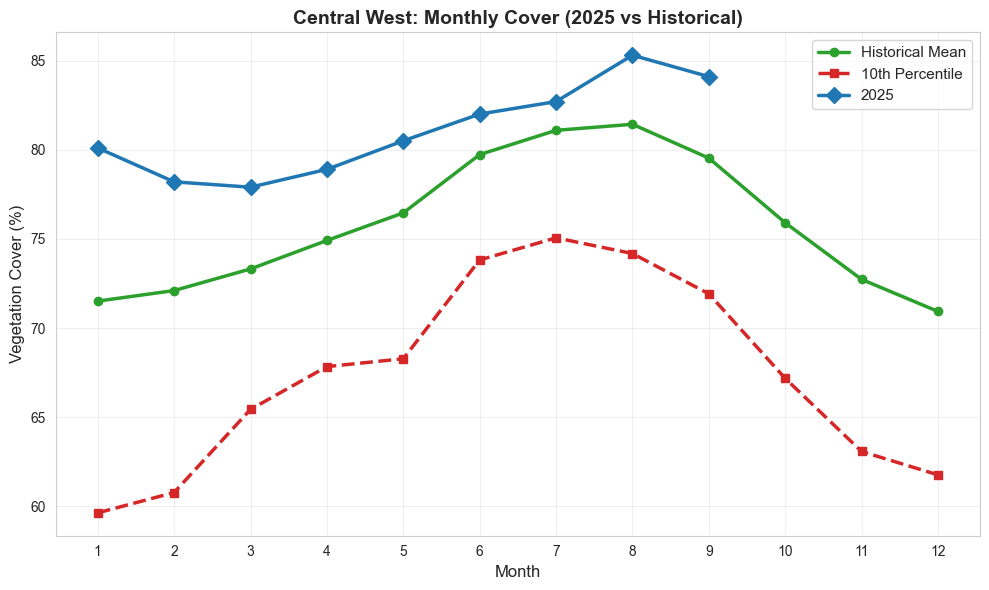

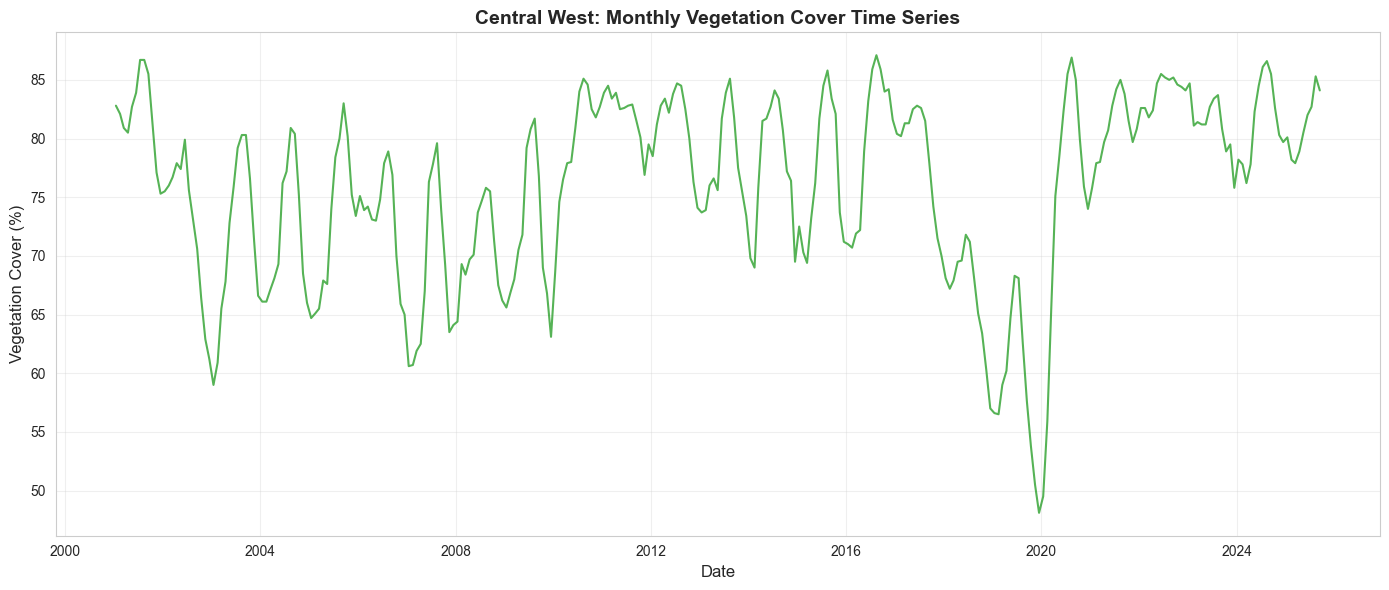

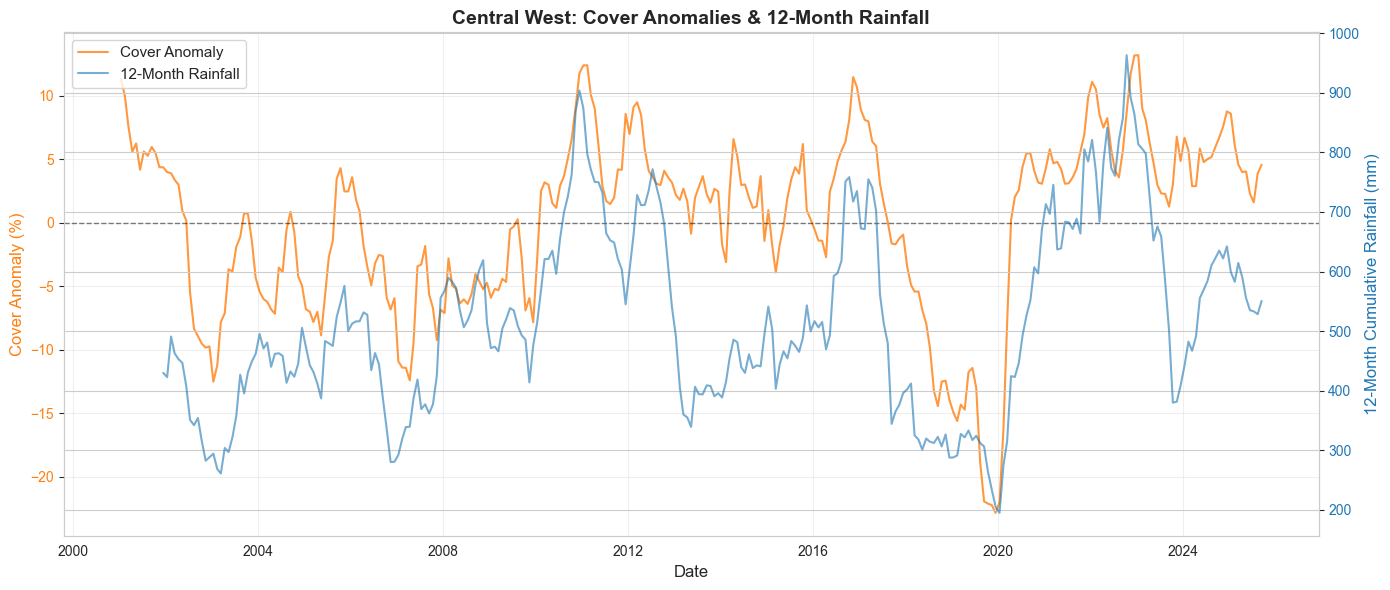

In [17]:
def plot_monthly_cover_summary(df: pd.DataFrame, current_year: int, dataset_name: str):
    """
    Compare current year's monthly vegetation cover to historical statistics.
    """
    monthly_mean = df.groupby('month')['mean_cover'].mean()
    monthly_p10 = df.groupby('month')['mean_cover'].quantile(0.10)
    df_current = df[df['year'] == current_year].set_index('month')['mean_cover']
    
    plt.figure(figsize=(10,6))
    plt.plot(monthly_mean.index, monthly_mean.values, 
             color=ColorScheme.VEGETATION, lw=2.5, label='Historical Mean', marker='o')
    plt.plot(monthly_p10.index, monthly_p10.values, 
             color=ColorScheme.RISK_HIGH, lw=2.5, linestyle='--', label='10th Percentile', marker='s')
    plt.plot(df_current.index, df_current.values, 
             color=ColorScheme.RAINFALL, lw=2.5, marker='D', markersize=8, label=f'{current_year}')
    
    plt.title(f"{dataset_name}: Monthly Cover ({current_year} vs Historical)", fontsize=14, fontweight='bold')
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Vegetation Cover (%)", fontsize=12)
    plt.xticks(range(1,13))
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_time_series(df: pd.DataFrame, dataset_name: str):
    """
    Plot the full time series of vegetation cover.
    """
    plt.figure(figsize=(14,6))
    plt.plot(df['date'], df['mean_cover'], color=ColorScheme.VEGETATION, alpha=0.8, linewidth=1.5)
    plt.title(f"{dataset_name}: Monthly Vegetation Cover Time Series", fontsize=14, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Vegetation Cover (%)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_cover_anomalies(df: pd.DataFrame, dataset_name: str):
    """
    Plot vegetation cover anomalies and 12-month cumulative rainfall using dual y-axes.
    """
    fig, ax1 = plt.subplots(figsize=(14,6))
    
    ax1.plot(df['date'], df['cover_anomaly'], color=ColorScheme.ANOMALY, alpha=0.8, linewidth=1.5, label='Cover Anomaly')
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax1.set_xlabel("Date", fontsize=12)
    ax1.set_ylabel("Cover Anomaly (%)", fontsize=12, color=ColorScheme.ANOMALY)
    ax1.tick_params(axis='y', labelcolor=ColorScheme.ANOMALY)
    ax1.grid(True, alpha=0.3)
    
    ax2 = ax1.twinx()
    ax2.plot(df['date'], df['rain_12mo'], color=ColorScheme.RAINFALL, alpha=0.6, linewidth=1.5, label='12-Month Rainfall')
    ax2.set_ylabel("12-Month Cumulative Rainfall (mm)", fontsize=12, color=ColorScheme.RAINFALL)
    ax2.tick_params(axis='y', labelcolor=ColorScheme.RAINFALL)
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11)
    
    plt.title(f"{dataset_name}: Cover Anomalies & 12-Month Rainfall", fontsize=14, fontweight='bold')
    fig.tight_layout()
    plt.show()


# Generate descriptive figures
current_year = 2025  # Update as needed
seasonal_cover = compute_seasonal_cycle(df)
df = compute_cover_anomalies(df, seasonal_cover)
df = compute_rolling_rainfall(df)

# Plot visualizations
plot_monthly_cover_summary(df, current_year, dataset_name)
plot_time_series(df, dataset_name)
plot_cover_anomalies(df, dataset_name)

## 4. Regression Analysis


OLS REGRESSION ANALYSIS

R²: 0.5949
Adj. R²: 0.5935
F-statistic: 417.09 (p-value: 1.14e-57)
Intercept: -18.2116
Slope (rain_12mo): 0.0347


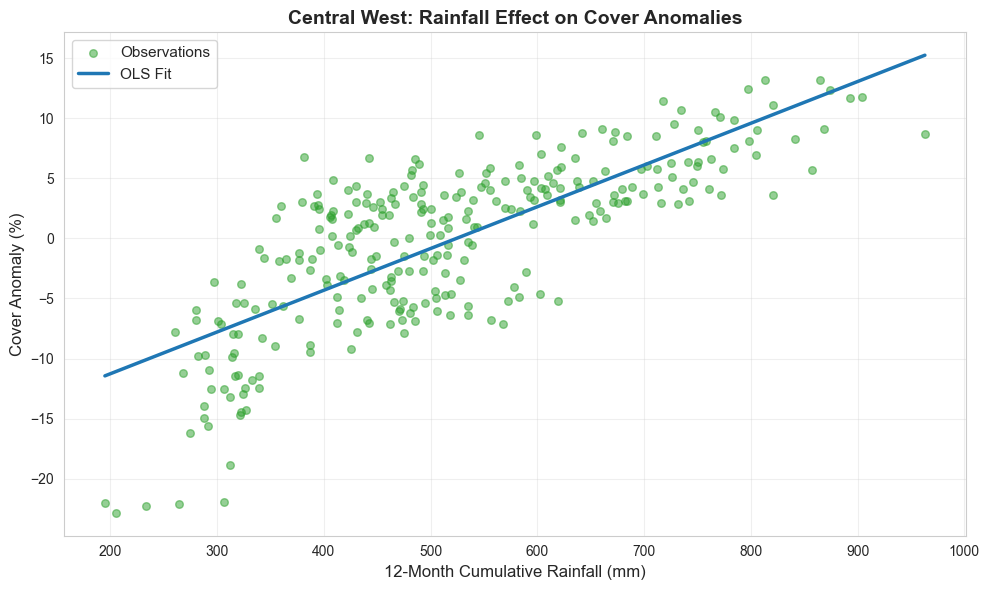

In [18]:
def fit_ols_regression(df: pd.DataFrame) -> Tuple[sm.regression.linear_model.RegressionResultsWrapper, pd.DataFrame]:
    """
    Fit an Ordinary Least Squares (OLS) regression of cover anomaly on 12-month cumulative rainfall.

    Returns:
    --------
    model : statsmodels RegressionResultsWrapper
        Fitted OLS model
    df_reg : pd.DataFrame
        Clean dataframe used for regression (no NaNs)
    """
    df_reg = df.dropna(subset=['rain_12mo','cover_anomaly']).copy()
    X = sm.add_constant(df_reg['rain_12mo'])
    y = df_reg['cover_anomaly']
    model = sm.OLS(y, X).fit()
    return model, df_reg


def plot_rainfall_regression(df: pd.DataFrame, model, dataset_name: str):
    """
    Plot observed cover anomalies vs 12-month rainfall and overlay OLS regression line.
    """
    plt.figure(figsize=(10,6))
    plt.scatter(df['rain_12mo'], df['cover_anomaly'], alpha=0.5, color=ColorScheme.VEGETATION, s=30, label='Observations')
    X_sorted = np.sort(df['rain_12mo'].values)
    pred_line = model.predict(sm.add_constant(X_sorted))
    plt.plot(X_sorted, pred_line, color=ColorScheme.RAINFALL, linewidth=2.5, label='OLS Fit')
    plt.title(f"{dataset_name}: Rainfall Effect on Cover Anomalies", fontsize=14, fontweight='bold')
    plt.xlabel("12-Month Cumulative Rainfall (mm)", fontsize=12)
    plt.ylabel("Cover Anomaly (%)", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run OLS Regression
print("\n" + "="*70)
print("OLS REGRESSION ANALYSIS")
print("="*70)

ols_model, df_reg = fit_ols_regression(df)

# Print key statistics
print(f"\nR²: {ols_model.rsquared:.4f}")
print(f"Adj. R²: {ols_model.rsquared_adj:.4f}")
print(f"F-statistic: {ols_model.fvalue:.2f} (p-value: {ols_model.f_pvalue:.2e})")
print(f"Intercept: {ols_model.params['const']:.4f}")
print(f"Slope (rain_12mo): {ols_model.params['rain_12mo']:.4f}")

# Plot regression
plot_rainfall_regression(df_reg, ols_model, dataset_name)

## 5. Forward-Chaining Logistic Regression, Probabilities & Risk Assessment


FORWARD-CHAINING CROSS-VALIDATION RESULTS

Confusion Matrix:
[[118  33]
 [  0  15]]

Performance Metrics:
  Accuracy:  0.801
  Precision: 0.312
  Recall:    1.000
  F1-Score:  0.476
  ROC AUC:   0.982



<IPython.core.display.Math object>


CURRENT RISK ASSESSMENT: Central West
Latest observation: September 2025
Current vegetation cover: 84.1%
12-month cumulative rainfall: 550.6 mm

Predicted probability of low cover: 10.4%
Risk Level: 🟢 LOW RISK



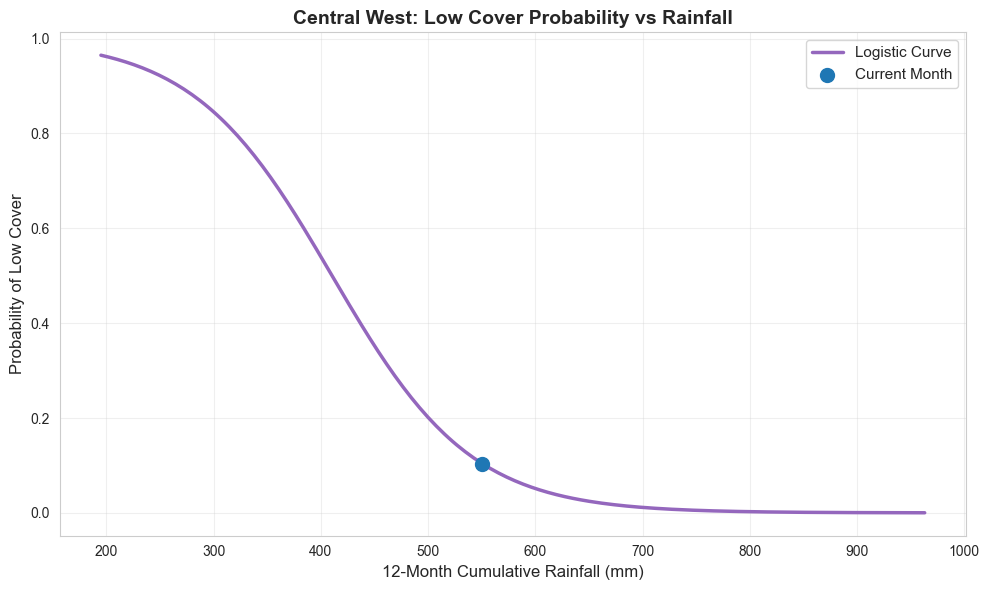

In [19]:
def evaluate_classification(y_true: np.ndarray, pred_probs: np.ndarray) -> Dict:
    """Calculate classification metrics"""
    y_pred = (pred_probs >= Config.PROB_THRESHOLD).astype(int)
    metrics = {
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, pred_probs) if len(np.unique(y_true)) > 1 else np.nan
    }
    return metrics


def forward_chaining_logistic(
    df: pd.DataFrame, 
    cover_threshold: float,
    initial_train_months: int = Config.INITIAL_TRAIN_MONTHS
) -> Tuple[LogisticRegression, np.ndarray, np.ndarray, Dict]:
    """
    Forward-chaining cross-validation for logistic regression model
    
    Returns:
        - final_model: LogisticRegression trained on all available data
        - pred_probs: Out-of-sample predicted probabilities
        - y_true: True labels for evaluation
        - metrics: Dictionary of performance metrics
    """
    df_clean = df.dropna(subset=['rain_12mo', 'mean_cover']).copy()
    if len(df_clean) < initial_train_months:
        raise ValueError(f"Insufficient data: {len(df_clean)} rows available, "
                         f"{initial_train_months} required for initial training")
    
    pred_probs, y_true = [], []
    
    # Forward-chaining cross-validation
    for fold_end in range(initial_train_months, len(df_clean)):
        X_train = df_clean.iloc[:fold_end][['rain_12mo']].values
        y_train = (df_clean.iloc[:fold_end]['mean_cover'] < cover_threshold).astype(int).values
        X_test = df_clean.iloc[[fold_end]][['rain_12mo']].values
        y_test = (df_clean.iloc[[fold_end]]['mean_cover'] < cover_threshold).astype(int).values
        
        model = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000)
        model.fit(X_train, y_train)
        pred_probs.append(model.predict_proba(X_test)[:,1][0])
        y_true.append(y_test[0])
    
    pred_probs = np.array(pred_probs)
    y_true = np.array(y_true)
    
    # Train final model on full dataset
    X_full = df_clean[['rain_12mo']].values
    y_full = (df_clean['mean_cover'] < cover_threshold).astype(int).values
    final_model = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000)
    final_model.fit(X_full, y_full)
    
    metrics = evaluate_classification(y_true, pred_probs)
    
    return final_model, pred_probs, y_true, metrics


def print_classification_results(metrics: Dict):
    """Print forward-chaining cross-validation results"""
    print("\n" + "="*70)
    print("FORWARD-CHAINING CROSS-VALIDATION RESULTS")
    print("="*70)
    print("\nConfusion Matrix:")
    print(metrics['confusion_matrix'])
    print(f"\nPerformance Metrics:")
    print(f"  Accuracy:  {metrics['accuracy']:.3f}")
    print(f"  Precision: {metrics['precision']:.3f}")
    print(f"  Recall:    {metrics['recall']:.3f}")
    print(f"  F1-Score:  {metrics['f1_score']:.3f}")
    print(f"  ROC AUC:   {metrics['roc_auc']:.3f}")
    print("="*70 + "\n")


def print_logistic_equation(model: LogisticRegression):
    """
    Display logistic regression equation in nicely formatted LaTeX.
    """
    intercept = model.intercept_[0]
    coef = model.coef_[0][0]
    
    # LaTeX string for the logistic function
    latex_str = r"P(\text{Low Cover}) = \frac{1}{1 + e^{-z}}, \quad z = %.4f %+ .6f \times \text{Rain}_{12mo}" % (intercept, coef)
    
    display(Math(latex_str))


def predict_current_risk(df: pd.DataFrame, model: LogisticRegression, dataset_name: str) -> float:
    """Predict low cover probability for most recent month"""
    df_latest = df.dropna(subset=['rain_12mo']).iloc[-1]
    rain_12mo = df_latest['rain_12mo']
    current_cover = df_latest['mean_cover']
    prob_low = model.predict_proba([[rain_12mo]])[0,1]
    
    print("\n" + "="*70)
    print(f"CURRENT RISK ASSESSMENT: {dataset_name}")
    print("="*70)
    print(f"Latest observation: {df_latest['date'].strftime('%B %Y')}")
    print(f"Current vegetation cover: {current_cover:.1f}%")
    print(f"12-month cumulative rainfall: {rain_12mo:.1f} mm")
    print(f"\nPredicted probability of low cover: {prob_low*100:.1f}%")
    
    if prob_low > 0.7:
        risk_level, risk_color = "HIGH RISK", "🔴"
    elif prob_low > 0.4:
        risk_level, risk_color = "MODERATE RISK", "🟡"
    else:
        risk_level, risk_color = "LOW RISK", "🟢"
    
    print(f"Risk Level: {risk_color} {risk_level}")
    print("="*70 + "\n")
    
    return prob_low

def plot_logistic_curve(df: pd.DataFrame, model: LogisticRegression, dataset_name: str):
    """
    Plot logistic regression probability curve and mark the latest observation.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataframe with 'rain_12mo'
    model : LogisticRegression
        Fitted logistic regression model
    dataset_name : str
        Name for plot title
    """
    # Create range of rainfall values for smooth curve
    rain_vals = np.linspace(df['rain_12mo'].min(), df['rain_12mo'].max(), 200).reshape(-1,1)
    prob_vals = model.predict_proba(rain_vals)[:,1]
    
    # Latest observation
    df_latest = df.dropna(subset=['rain_12mo']).iloc[-1]
    latest_rain = df_latest['rain_12mo']
    latest_prob = model.predict_proba([[latest_rain]])[0,1]
    
    plt.figure(figsize=(10,6))
    plt.plot(rain_vals, prob_vals, color=ColorScheme.PROBABILITY, lw=2.5, label='Logistic Curve')
    plt.scatter(latest_rain, latest_prob, color=ColorScheme.RAINFALL, s=100, zorder=5, label='Current Month')
    
    plt.xlabel("12-Month Cumulative Rainfall (mm)", fontsize=12)
    plt.ylabel("Probability of Low Cover", fontsize=12)
    plt.title(f"{dataset_name}: Low Cover Probability vs Rainfall", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()


# Run Forward-Chaining Logistic Regression
cover_threshold = df['mean_cover'].quantile(Config.LOW_COVER_THRESHOLD)

final_model, pred_probs, y_true, metrics = forward_chaining_logistic(df, cover_threshold)
print_classification_results(metrics)
print_logistic_equation(final_model)
predict_current_risk(df, final_model, dataset_name)
plot_logistic_curve(df, final_model, dataset_name)